In [1]:
%pylab inline
import emcee
import programas as pg

Populating the interactive namespace from numpy and matplotlib


In [2]:
f0_file = np.load('f0_perfiles.npy')
f1_file = np.load('f1_perfiles.npy')
f2_file = np.load('f2_perfiles.npy')
f4_file = np.load('f4_perfiles.npy')

f0 = f0_file[:,1:]
f1 = f1_file[:,1:]
f2 = f2_file[:,1:]
f4 = f4_file[:,1:]

In [3]:
# Función de verosimilitud
def log_likelihood(params, F_obs, F0, F1, F2, F4, C_inv):
    b1, b2, b4 = params
    model = F0 + b1 * F1 + b2 * F2 + b4*F4 - 1
    diff = F_obs - model
    return -0.5 * np.dot(diff, np.dot(C_inv, diff))

# Priors
def log_prior(params):
    b1, b2, b4 = params
    if -5 < b1 < 6 and -10 < b2 < 10 and -20 < b4 < 10:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, F_obs, F0, F1, F2, F4, C_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, F_obs, F0, F1, F2, F4, C_inv)

In [4]:
realizaciones = 80

mean_0, error_0 = pg.perfil_jack(f0,realizaciones)
mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
mean_4, error_4 = pg.perfil_jack(f4,realizaciones)

In [5]:
original = np.load('observacion_perfiles.npy')
obs = original[:,1:]
mean_obs, error_obs = pg.perfil_jack(obs,realizaciones)

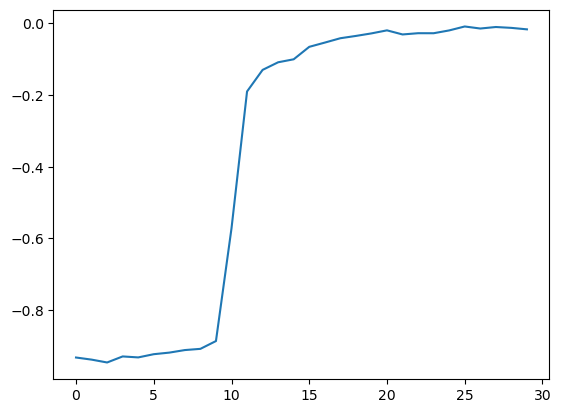

In [6]:
plt.plot(mean_obs)

In [7]:
def perfil_jack(perfiles,realizaciones):
    # calcula el perfil con error jacknife y matriz
    # de covarianza 
    voidnumber = perfiles.shape[0]
    voidbines = perfiles.shape[1]
    ndivision = int(voidnumber/realizaciones)

    perfiles_jack = np.zeros([realizaciones,voidbines])
    
    total_ids = np.arange(0,voidnumber)

    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
    
    # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        perfiles_jack[i,:] = pg.mean_profile(perfiles[selection,:].T)
        
        exclude0 = exclude1
        
    perfiles_mean = np.zeros(voidbines)
    perfiles_error = np.zeros(voidbines)

    n = realizaciones
    for i in range(voidbines):
        media = np.mean(perfiles_jack[:,i])
        error = np.sqrt(((n-1)/n) * np.sum((perfiles_jack[:,i]-media)**2))
    
        perfiles_mean[i]  = media
        perfiles_error[i] = error
        
    return perfiles_mean, perfiles_error, perfiles_jack

In [8]:
# IMPORTANTE: numero de jacknife tiene que ser mayor que el numero de bines (sino no puede invertirse)
realizaciones = 80
mean_obs, error_obs, all_obs = perfil_jack(obs,realizaciones)

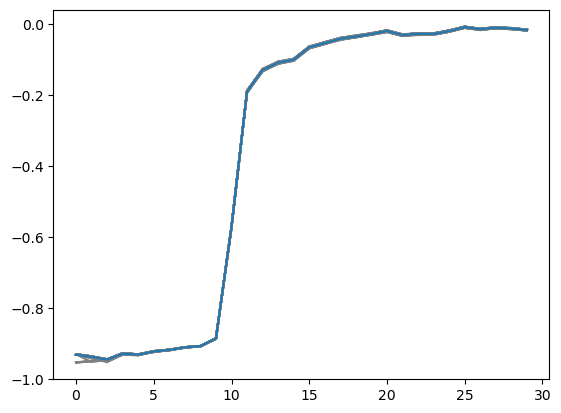

In [9]:
for i in range(all_obs.shape[0]):
    plt.plot(all_obs[i,:],color='grey')
plt.plot(mean_obs)

In [10]:
def covariance_mat(pmean, pall):
    
    njack  = pall.shape[0]
    nbines = pall.shape[1]
    C = np.zeros([nbines,nbines])
    
    for i in range(nbines):
        dif_pi = pall[:,i] - pmean[i]
        
        for j in range(nbines):
            dif_pj = pall[:,j] - pmean[j]
            
            C[i,j] = np.sum(dif_pi*dif_pj)
            
    C = ((njack-1)/njack)*C        
    return C

In [11]:
C = covariance_mat(mean_obs,all_obs)

# normalization:
ies = C.shape[0]
jes = C.shape[1]

C_new = np.zeros([ies,jes])

for i in range(ies):
    for j in range(jes):
        
        C_new[i,j] = C[i,j]/np.sqrt(C[i,i]*C[j,j])
        
C = C_new

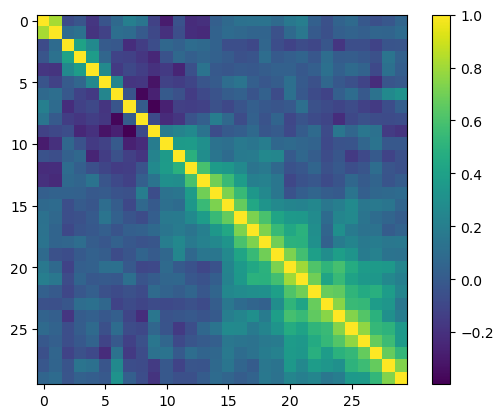

In [12]:
plt.imshow(C_new)
plt.colorbar()

In [13]:
F_obs = mean_obs
F0 = mean_0
F1 = mean_1
F2 = mean_2
F4 = mean_4


# Inverso de la matriz de covarianza
C_inv = np.linalg.inv(C)

# Configuración de MCMC
ndim = 3  # Número de parámetros
nwalkers = 50  # Número de walkers
nsteps = 3000  # Número de pasos

# Inicializar walkers aleatoriamente
starting_guesses = np.random.rand(nwalkers, ndim)

# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F0, F1, F2, F4, C_inv))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1013.51it/s]


State([[  0.2733464   -3.06236071   5.85738544]
 [  1.66729815   2.14050101   1.77482334]
 [  0.05515208  -4.36329247 -19.1077409 ]
 [ -1.32429245  -6.34211505 -17.41242164]
 [  3.16203551   7.1727221    1.04944088]
 [  0.3409136   -2.08039901 -14.2395474 ]
 [  2.15030382   3.74274433   2.97417222]
 [ -1.48538441  -7.64490832  -8.6298335 ]
 [  0.53429395  -2.15559568 -12.99703824]
 [ -1.70087075  -8.75374268 -11.87524999]
 [  1.94539822   2.30525593   2.70628427]
 [ -1.26870194  -8.02714638  -9.03500369]
 [ -0.77493799  -6.14771281  -4.52126422]
 [ -0.18009653  -3.92873991   9.59602894]
 [  2.79230924   6.49449951   5.65078539]
 [  3.18988753   7.07746056  -0.85476568]
 [  1.74495889   2.99808672 -18.6445599 ]
 [  1.68935488   3.33622256  -3.36021226]
 [  3.36878255   7.88018883 -15.35758899]
 [ -0.36069444  -5.39773805   0.67355112]
 [ -0.12742716  -4.95719286 -17.7423923 ]
 [  2.27587203   4.2675591    8.93911915]
 [ -0.3351206   -4.6906152   -8.1763129 ]
 [  1.78401113   2.91314623 

In [14]:
# Análisis de resultados
samples = sampler.get_chain(discard=100, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
b1_samples, b2_samples, b4_samples = samples[:, 0], samples[:, 1], samples[:,2]

b1 = 1.1386286967877237 ± 1.4052803145352606
b2 = 0.4523373081771233 ± 4.865163930949073
b4 = -5.074477060820653 ± 8.689993780644482


Text(0, 0.5, '$\\theta_4$')

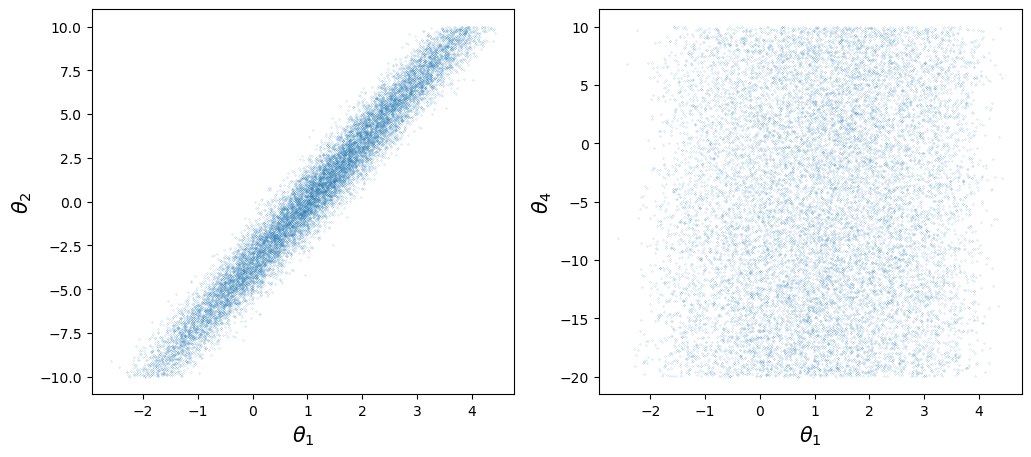

In [15]:
# Calcular medias y desviaciones estándar
b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)

print(f"b1 = {b1_mean} ± {b1_std}")
print(f"b2 = {b2_mean} ± {b2_std}")
print(f"b4 = {b4_mean} ± {b4_std}")


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(b1_samples,b2_samples,ls='none',marker='o',markersize=.1)
plt.xlabel('$\\theta_1$',size=15)
plt.ylabel('$\\theta_2$',size=15)

plt.subplot(122)
plt.plot(b1_samples,b4_samples,ls='none',marker='o',markersize=.1)
plt.xlabel('$\\theta_1$',size=15)
plt.ylabel('$\\theta_4$',size=15)

In [16]:
#b1_jens = 1.13
#b2_jens = 0.55
#b4_jens = -1.19

b1_jens = 0.98627658  
b2_jens = 0.04201587 
b4_jens = -5.56445679

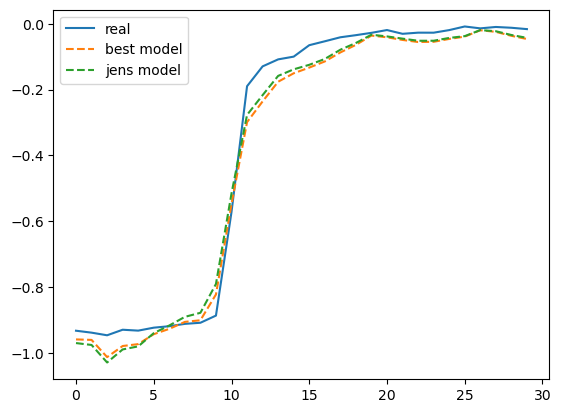

In [17]:
plt.plot(F_obs, label='real')
plt.plot(F0 + b1_mean*F1 + b2_mean*F2 + b4_mean*F4 - 1, ls='dashed', label='best model')
plt.plot(F0 + b1_jens*F1 + b2_jens*F2 + b4_jens*F4 - 1, ls='dashed', label='jens model')

#plt.plot(F1,label='F1')
#plt.plot(F2,label='F2')
plt.legend()
#plt.ylim(-1.4,0.2)

In [49]:
sampler.run_mcmc?

Signature: sampler.run_mcmc(initial_state, nsteps, **kwargs)
Docstring:
Iterate :func:`sample` for ``nsteps`` iterations and return the result

Args:
    initial_state: The initial state or position vector. Can also be
        ``None`` to resume from where :func:``run_mcmc`` left off the
        last time it executed.
    nsteps: The number of steps to run.

Other parameters are directly passed to :func:`sample`.

This method returns the most recent result from :func:`sample`.
File:      ~/miniconda3/lib/python3.7/site-packages/emcee/ensemble.py
Type:      method
